# Reinforcement Learning -- Economic Example

**Prerequisites**

- Dynamic Programming
- Reinforcement Learning Introduction
- Reinforcement Learning Sarsa algorithm
- Reinforcement Learning Q-learning algorithm

**Outcomes**

- Understand the main points of the career choice model of Derek Neal
- See how career choice model can be cast as a RL problem
- Use Sarsa and QLearning to "solve" career choice model

**References**

- Barto & Sutton book (online by authors [here](http://incompleteideas.net/book/the-book.html)) chapters 4-6
- [QuantEcon lecture](https://python.quantecon.org/career.html) on career choice model 

## Disclaimer: Julia

- The code for this notebook is written in the [Julia](https://julialang.org) programming language
- Julia is a newer language created specificly for doing numerical computing
- It is friendly like Python, but can run *much* faster
- Most of the code for this example in in a file `neal.jl`, which we will not study directly
- The examples that do appear in the notebook will be commented and should be similar enough to Python for us to follow
- To learn more about Julia, we recommend the [QuantEcon Julia Lectures](https://julia.quantecon.org/)

> Note: using Julia was necessary to have the code run quickly enough...

## Career Model

- We'll summarize the model here
- See the [QuantEcon lecture](https://python.quantecon.org/career.html) for more details
- Workers have a career and a job
    - Career is general field
    - Job is position within a firm -- many jobs per career
- Wage has career and job component: $$w_t = \underbrace{\theta_t}_{\text{career part}} + \underbrace{\epsilon_t}_{\text{job part}}$$
- Each period, worker has three mutually exclusive choices
    1. Stay at job -- "stay put"
    2. Switch jobs in same career -- "new job"
    3. Swich careers (requires new job) -- "new life"
- Draws of $\theta$ and $\epsilon$ are time-invariant:$$\theta_t \sim F, \epsilon_t \sim G \quad \forall t$$
- New $\epsilon$ and $\theta$ are only drawn when a worker switches jobs or careers

### State Value Function

- State of model is $s = (\theta, \epsilon)$
- The state value function obeys
$$
\begin{aligned}
v(\theta, \epsilon) &= \max\{I, II, III\}, \text{ where} \\
& I = \theta + \epsilon + \beta v(\theta, \epsilon) \\
& II = \theta + E[ \epsilon' + \beta  v(\theta, \epsilon')  | \epsilon' \sim G] \\
& III = E[\theta' + \epsilon' + \beta v(\theta', \epsilon') |  \epsilon' \sim G, \theta' \sim F]
\end{aligned}
$$
- $I$, $II$, and $III$ correspond to value of "stay put", "new job", "new life"; respectively

### Action Value Function


- The action space is $\mathcal{A} = \{\text{stay put}, \text{ new job}, \text{ new life} \}$ for all states
- The action value function $Q(s, a)$ is:
$$
\begin{aligned}
Q(\theta, \epsilon, \text{ stay put}) &= \theta + \epsilon + \beta \max_{a'} Q(\theta, \epsilon, a') \\
Q(\theta, \epsilon, \text{ new job}) &= \theta + E[ \epsilon' + \beta  \max_{a'} Q(\theta, \epsilon', a')  | \epsilon' \sim G] \\
Q(\theta, \epsilon, \text{ new life}) &= E[\theta' + \epsilon' + \beta  \max_{a'} Q(\theta', \epsilon', a')  | \epsilon' \sim G, \theta' \sim F] \\
\end{aligned}
$$

### Discrete Distributions

- In our examples today, we will use discrete distributions for $F$ and $G$
- There will be a finite number of possible $\epsilon$ and $\theta$ -- each with a fixed probability of being drawn from their repsective distributions

In [1]:
# set up all dependencies for this code
using Pkg
Pkg.activate(".")
Pkg.resolve()

# load up example code
include("src/Career.jl")
using .Career

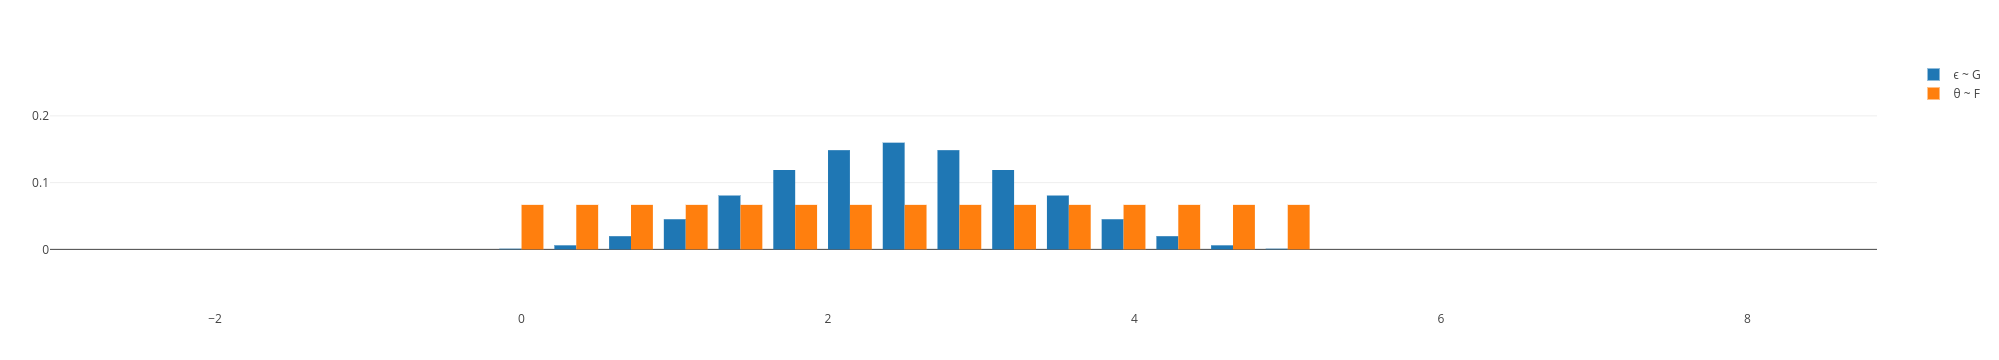

In [7]:
m = NealDSDC(N=15);
plot_distributions(m)

Notes: 

- Both $\theta$ and $\epsilon$ live in [0, 5]
- $\theta$ is uniformly distributed
- $\epsilon$ looks to be nearly Gaussian on that range

### Optimal solution via Dynamic Programming

- We can apply dynamic programming methods to solve this model numerically
- We have code that can solve model this via value function iteration
- Here's the state value function $v^*$ for this model:

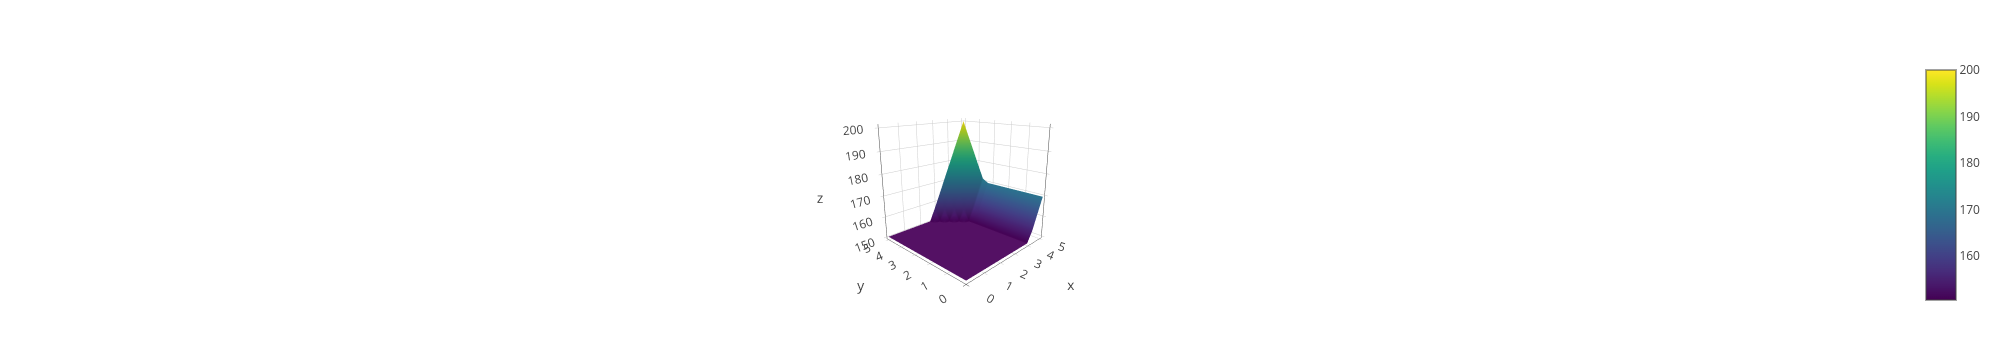

In [8]:
plot_vf(m)

#### Policy function $a^*(s)$

- Optimal policy function is easier to read/understand
- We'll look more at it

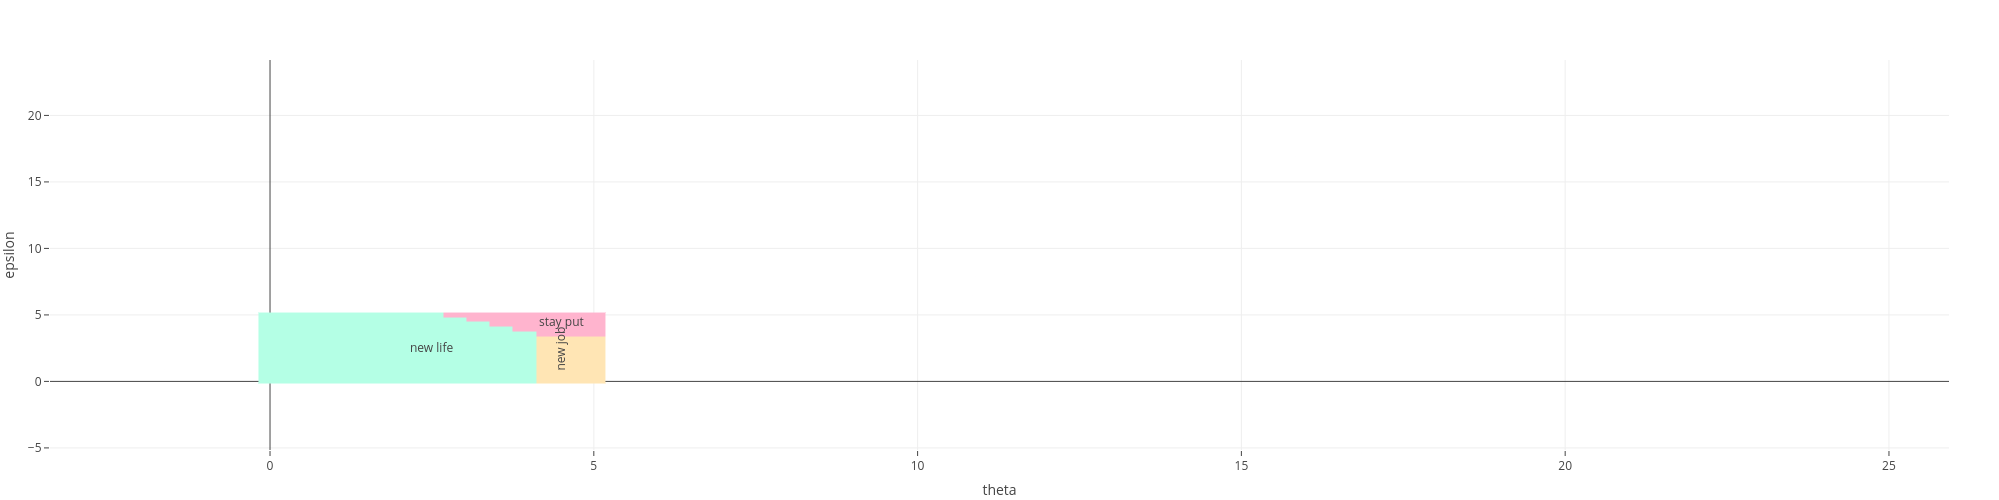

In [9]:
plot_policy(m)

Notes

- If both job and career are good, worker stays put
- If career is good, worker explores new jobs until $\epsilon$ is sufficiently high
- If neither is very good, worker re-draws both career and job

#### Comment on model knowledge

- See code for `bellman_operator!` repeated below
- Note in doing VFI and leveraging this operator, we let algorithm (VFI) know the model for $\theta$ and $\epsilon$ (we use $F$ and $G$ to take expectations)

```julia
function bellman_operator!(m::NealDSDC, v::Array, out::Array;
                           ret_policy=false)
    # new life. This is a function of the distribution parameters and is
    # always constant. No need to recompute it in the loop
    v3 = (m.G_mean + m.F_mean + m.beta .* (m.F_probs' * v * m.G_probs))

    for j=1:m.N
        for i=1:m.N
            # stay put
            v1 = m.θ[i] + m.ϵ[j] + m.beta * v[i, j]

            # new job
            v2 = m.θ[i] + m.G_mean + m.beta * dot(v[i, :], m.G_probs)

            if ret_policy
                if v1 >= max(v2, v3)
                    action = 1
                elseif v2 >= max(v1, v3)
                    action = 2
                else
                    action = 3
                end
                out[i, j] = action
            else
                out[i, j] = max(v1, v2, v3)
            end
        end
    end
end
```

## Model-free learning

- RL algorithms like Sarsa and Q-learning are model-free algorithms
- They do not take into account any specialized structure about the environment
- Sarsa and Q-learning learn entirely from trial and error
- Benefits: can learn in situations where we don't know dynamics
- Downfalls: don't leverage model structure to accelerate learning ==> takes longer!

### Sarsa for career model

- Inside the `src/neal.jl` file you see the following code for the Sarsa algorithm

```julia
# Barto & Sutton Algorithm in figure 6.5
mutable struct Sarsa <: AbstractQAlgorithm
    Q::QFunction  # wrapper around 3d array (a, θ, ϵ)
    α::Float64
    
    # store (s, a) to use in updates
    s::State
    a::Action
end

function update!(wp::NealDSDC, actor::AbstractActor, algo::Sarsa)
    # use current state and action to do transition
    sp, r = step(wp, algo.s, algo.a)

    # get next action using actor's strategy
    ap = get_action(wp, algo, actor, sp)[1]

    # Apply TD update
    algo.Q[algo.s, algo.a] = (1-algo.α)*algo.Q[algo.s, algo.a] +
                             algo.α*(r + wp.beta * algo.Q[sp, ap])

    # step forward in time
    algo.s = sp
    algo.a = ap
end
```

- Below we'll set up a Sarsa model and plot the initial policy function

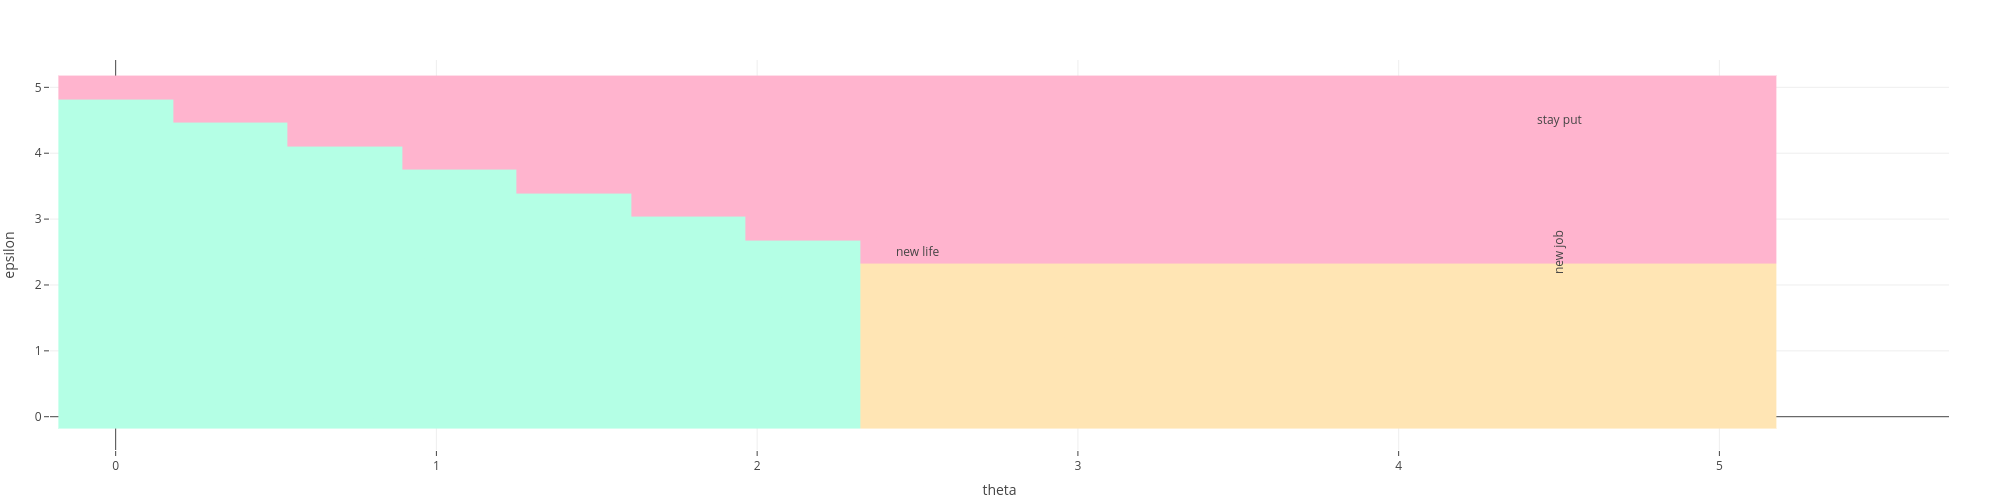

In [10]:
# set random seed
using Random  
Random.seed!(56)
sarsa = Sarsa(m, 0.01);

# plot initial policy
plot_policy(m, get_greedy(m, sarsa.Q))

- Now we will have Sarsa learn a policy by taking 150,000,000 steps

  6.712036 seconds (1.79 M allocations: 106.000 MiB, 0.31% gc time, 6.59% compilation time)


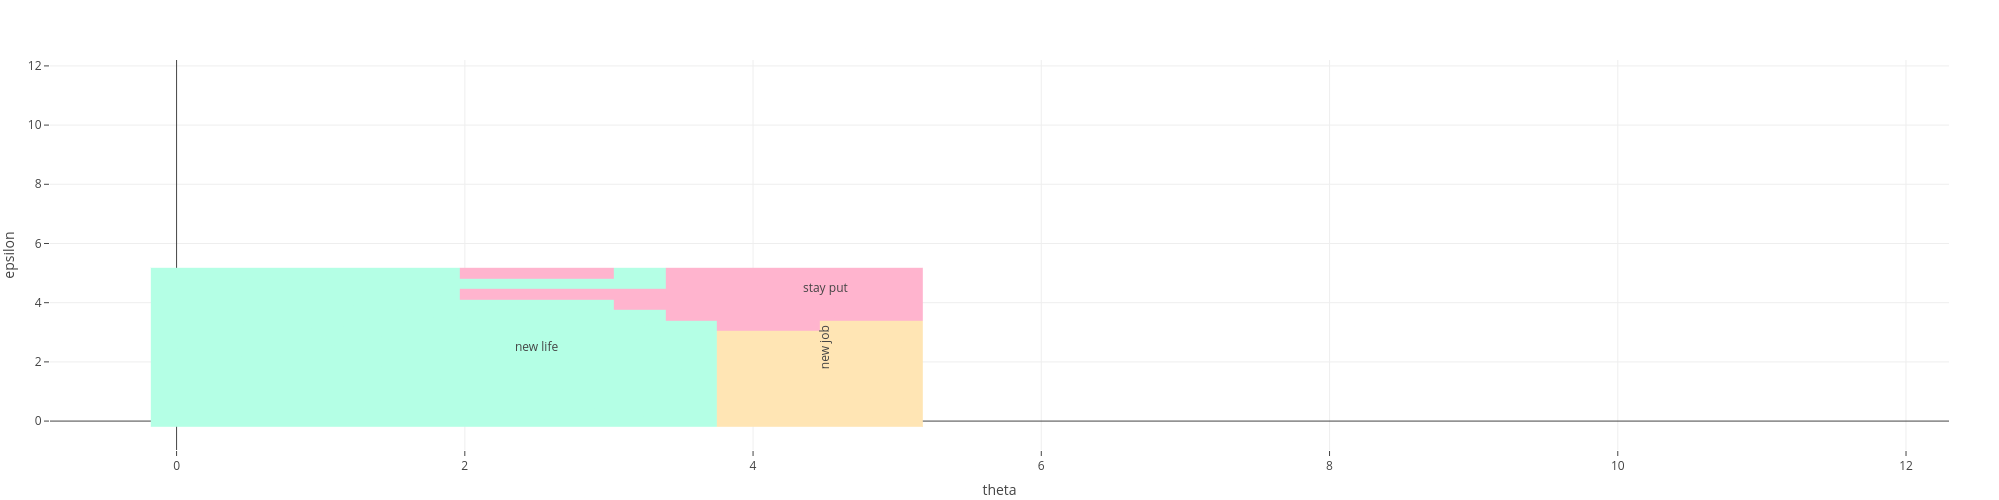

In [11]:
# epsilson is prob of random action
actor = EpsilonGreedy(1.0, 0.1, 10_000_000)
@time learn(m, sarsa, actor; maxit=150_000_000,  should_plot=false);

# plot final policy
plot_policy(m, get_greedy(m, sarsa.Q))

Notes

- This is not bad, but...
    - Sarsa  under-estimates the Q-function systematically
    - We'll see this by looking at "true q*" obtained via QFI

In [12]:
opt_Q = Career.qfi(m);

- We'll compare opt_Q to Sarsa's Q in the upper right corner of state space (where it seems to struggle most)

In [13]:
opt_Q[:, 8:10, 8:10] - sarsa.Q.q[:, 8:10, 8:10] 

3×3×3 Array{Float64, 3}:
[:, :, 1] =
  9.9898   9.89119   9.90818
 10.0404  10.1329   10.0137
 11.0849  10.5908   10.4959

[:, :, 2] =
  9.93097   9.94257  10.0245
 10.0652   10.0367    9.95953
 10.9327   10.1025   10.6261

[:, :, 3] =
 10.1664  10.1106  10.1637
 10.111   10.0961  10.0616
 10.7898  10.5648  10.5708

- $q^*$ higher everywhere 
- Part of issue is that $TD(0)$ is only accurate when Q is accurate and $\epsilon$ is zero (greedy updates)
- We don't set $\epsilon$ to zero, so we make some sub-optimal transitions, which introduces downward bias in $Q$

### Q-learning for career model

- We can use the off-policy Q-learning algorithm to overcome this problem
- In Q-learning, $TD(0)$ is always computed using greedy policy derived from $Q$
- This will remove large portion of downward bias we saw with Sarsa
- My implementation of Q-learning for this model is found below

```julia
# Barto & Sutton Algorithm in figure 6.7
mutable struct QLearning <: AbstractQAlgorithm
    Q::QFunction
    s::State
    α::Float64
end

function update!(wp::NealDSDC, actor::AbstractActor, algo::QLearning)
    # choose a
    a = get_action(wp, algo, actor, algo.s)[1]

    # use current state and action to do transition
    sp, r = step(wp, algo.s, a)

    # ap is greedy in Q
    ap = get_greedy(algo, sp)

    # Apply TD update
    algo.Q[algo.s, a] = (1-algo.α)*algo.Q[algo.s, a] +
                           algo.α*(r + wp.beta * algo.Q[sp, ap])

    # step forward in time
    algo.s = sp
end
```

- We'll run same experiment with Q-learning

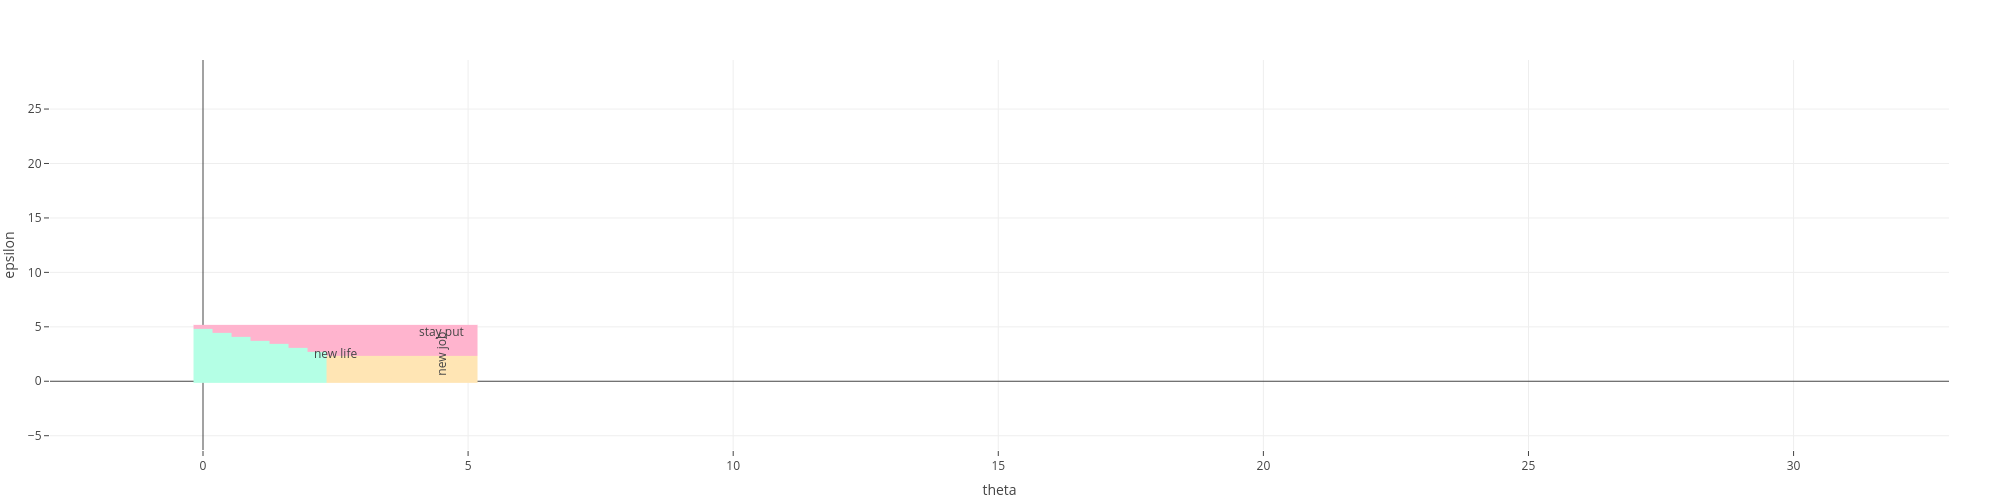

In [14]:
# reset random seed
Random.seed!(56)
qlearning = QLearning(m, 0.01);

# plot initial policy
plot_policy(m, get_greedy(m, qlearning.Q))

  8.096814 seconds (98.02 k allocations: 6.062 MiB, 0.96% compilation time)


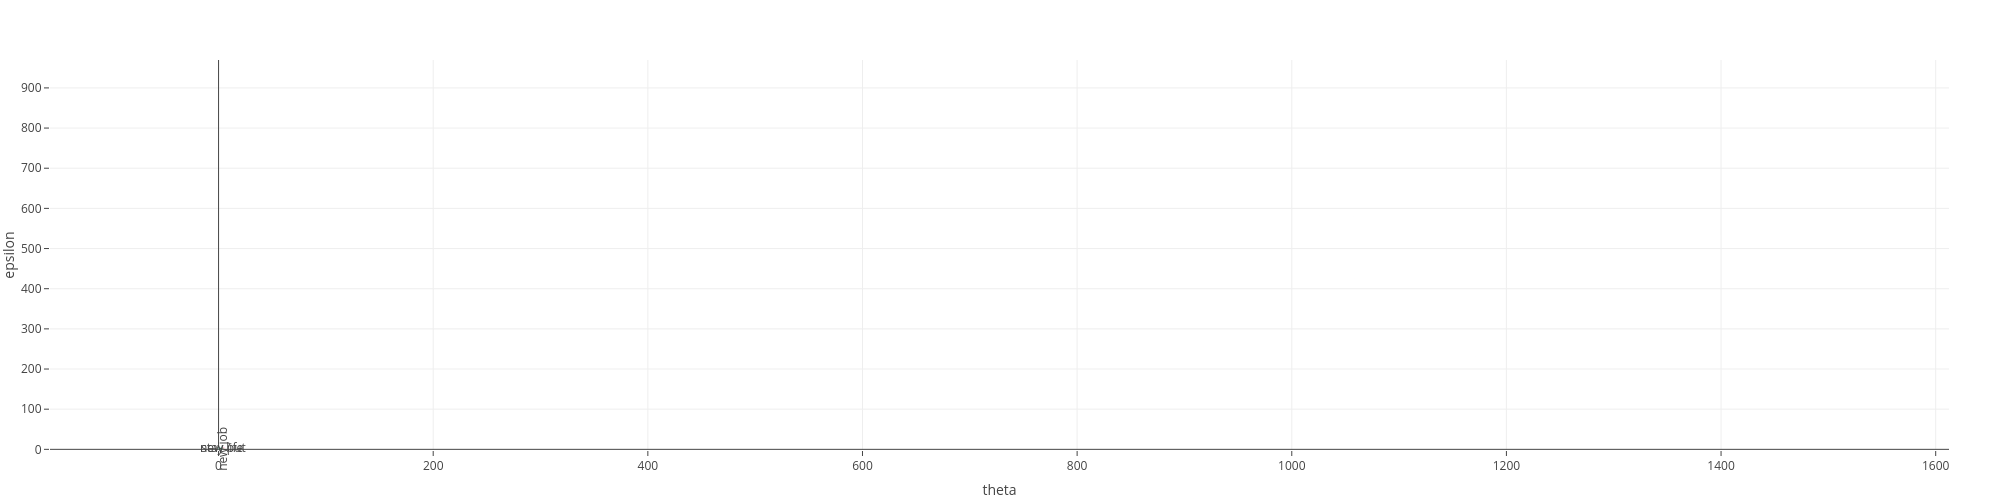

In [15]:
actor = EpsilonGreedy(1.0, 0.1, 10_000_000)
@time learn(m, qlearning, actor; maxit=150_000_000,  should_plot=false);

# plot final policy
plot_policy(m, get_greedy(m, qlearning.Q))

- Check the Q-learning Q function against $q^*$ and see bias is smaller:

In [16]:
opt_Q[:, 8:10, 8:10] - qlearning.Q.q[:, 8:10, 8:10] 

3×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.166843   0.349435  0.0305733
 0.186209   0.106912  0.223948
 0.707085  -0.592787  0.402138

[:, :, 2] =
  0.220097   0.197678  -0.0990846
  0.0473951  0.246321   0.0989512
 -0.332978   0.690139   0.218061

[:, :, 3] =
  0.260701   0.32411    0.603764
  0.0903624  0.101123  -0.0294898
 -0.286058   0.529283   0.407503